In [73]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [74]:
data = pd.read_csv('data.csv')
data.head()

,Местное время в Ростове-на-Дону,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,01.08.2023 21:00,26.7,749.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01.08.2023 18:00,31.2,748.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Осадков нет,12.0,NaN,NaN,NaN,NaN
2,01.08.2023 15:00,33.8,749.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01.08.2023 12:00,32.1,750.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01.08.2023 09:00,27.4,750.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Преобразовали тип данных в дату

In [75]:
data['Местное время в Ростове-на-Дону'] = data['Местное время в Ростове-на-Дону'].apply(lambda date: 
                                                                                        datetime.datetime.strptime(date, '%d.%m.%Y %H:%M'))
data['time'] = data['Местное время в Ростове-на-Дону'] 
data.index = data['time']
data = data.drop(['time', 'Местное время в Ростове-на-Дону'], axis=1)
data.head()

,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
time,,,,,,,,,,,,,,,,,,,,,
2023-08-01 21:00:00,26.7,749.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,60%.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-01 18:00:00,31.2,748.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,"90 или более, но не 100%",...,NaN,NaN,NaN,NaN,Осадков нет,12.0,NaN,NaN,NaN,NaN
2023-08-01 15:00:00,33.8,749.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN,70 – 80%.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-01 12:00:00,32.1,750.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,20–30%.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-01 09:00:00,27.4,750.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,40%.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='time'>

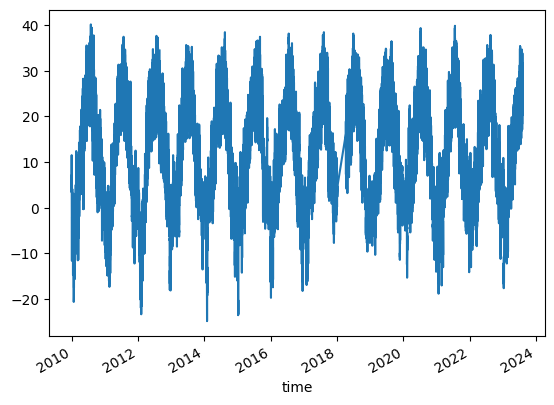

In [76]:
data['T'].plot()

Много столбоцов, в которых нет информации => оставляем только нужные:

In [77]:
# T - температура воздуха
# Po - Атмосферное давление ( в мм ртутного столба )
# U - Относительная влажность (в %)
# N - Общая облачость
# Tn - минимальная темп. воздуха за 12 часов
# Tx - максиммальная темп. воздуха за 12 часов
# RRR - кол-во выпавших осадков
data = data[['T', 'Po', 'U', 'N', 'Tn', 'Tx', 'RRR']]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38796 entries, 2023-08-01 21:00:00 to 2010-01-01 00:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       38771 non-null  float64
 1   Po      38749 non-null  float64
 2   U       38748 non-null  float64
 3   N       38385 non-null  object 
 4   Tn      6048 non-null   float64
 5   Tx      4837 non-null   float64
 6   RRR     8647 non-null   object 
dtypes: float64(5), object(2)
memory usage: 2.4+ MB


Не везде есть температура((( заменю позже

In [99]:
data.loc[data['T'].isnull()]

,T,Po,U,N,Tn,Tx,RRR
time,,,,,,,
2023-01-07 03:00:00,NaN,756.0,87.0,NaN,NaN,NaN,NaN
2022-12-01 09:00:00,NaN,768.0,NaN,40%.,-5.0,NaN,NaN
2022-12-01 06:00:00,NaN,768.0,NaN,Облаков нет.,-4.6,NaN,Осадков нет
2022-12-01 03:00:00,NaN,768.0,NaN,Облаков нет.,NaN,NaN,NaN
2022-12-01 00:00:00,NaN,768.0,NaN,Облаков нет.,NaN,NaN,NaN
2022-11-30 21:00:00,NaN,768.0,NaN,Облаков нет.,NaN,NaN,NaN
2022-04-12 15:00:00,NaN,746.0,90.0,100%.,NaN,NaN,NaN
2022-04-12 12:00:00,NaN,745.0,81.0,100%.,NaN,NaN,NaN
2022-02-21 09:00:00,NaN,754.0,NaN,"10% или менее, но не 0",NaN,NaN,NaN


In [100]:
data['month'] = data.index.month
data['hour'] = data.index.hour
data.head()

,T,Po,U,N,Tn,Tx,RRR,month,hour
time,,,,,,,,,
2023-08-01 21:00:00,26.7,749.0,43.0,60%.,NaN,NaN,NaN,8,21
2023-08-01 18:00:00,31.2,748.0,34.0,"90 или более, но не 100%",NaN,34.5,Осадков нет,8,18
2023-08-01 15:00:00,33.8,749.0,24.0,70 – 80%.,NaN,NaN,NaN,8,15
2023-08-01 12:00:00,32.1,750.0,34.0,20–30%.,NaN,NaN,NaN,8,12
2023-08-01 09:00:00,27.4,750.0,43.0,40%.,NaN,NaN,NaN,8,9


In [112]:
data['mean_month'] = list(map(dict(data.groupby(data.month)['T'].mean()).get, data['month'])) # среднемесячная температура
data.head()                         

,T,Po,U,N,Tn,Tx,RRR,month,hour,mean_month
time,,,,,,,,,,
2023-08-01 21:00:00,26.7,749.0,43.0,60%.,NaN,NaN,NaN,8,21,24.895906
2023-08-01 18:00:00,31.2,748.0,34.0,"90 или более, но не 100%",NaN,34.5,Осадков нет,8,18,24.895906
2023-08-01 15:00:00,33.8,749.0,24.0,70 – 80%.,NaN,NaN,NaN,8,15,24.895906
2023-08-01 12:00:00,32.1,750.0,34.0,20–30%.,NaN,NaN,NaN,8,12,24.895906
2023-08-01 09:00:00,27.4,750.0,43.0,40%.,NaN,NaN,NaN,8,9,24.895906


In [174]:
mean_hour = dict(data.groupby([data.month, data.hour])['T'].mean()) # средняя температура за час каждый месяц
data['mean_hour'] = None
for i in range(len(data)):
    month, hour = data.iloc[i]['month'], data.iloc[i]['hour']
    data.at[data.index[i], 'mean_hour'] = mean_hour[(month, hour)]
    
data.head()

TypeError: DataFrame._get_value() missing 1 required positional argument: 'col'

In [152]:
data.head()

,T,Po,U,N,Tn,Tx,RRR,month,hour,mean_month,mean_hour
time,,,,,,,,,,,
2023-08-01 21:00:00,26.7,749.0,43.0,60%.,NaN,NaN,NaN,8,21,24.895906,None
2023-08-01 18:00:00,31.2,748.0,34.0,"90 или более, но не 100%",NaN,34.5,Осадков нет,8,18,24.895906,None
2023-08-01 15:00:00,33.8,749.0,24.0,70 – 80%.,NaN,NaN,NaN,8,15,24.895906,None
2023-08-01 12:00:00,32.1,750.0,34.0,20–30%.,NaN,NaN,NaN,8,12,24.895906,None
2023-08-01 09:00:00,27.4,750.0,43.0,40%.,NaN,NaN,NaN,8,9,24.895906,None
